# Shipping time analysis to predict an accurate date of delivery and to reduce delays, in order to improve the quality of the shipping service (Delivery Time Prediction)

# Data Inspection

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

In [2]:
#upload the needed dataset
customers =pd.read_csv('02.customers_new.csv', encoding='latin-1', index_col=0)
geo = pd.read_csv('01.geo.csv', encoding='latin-1', sep=';')
sellers = pd.read_csv('03.sellers.csv' , encoding = 'latin-1',sep=';')
o_status = pd.read_csv('04.order_status.csv',sep=';')
products= pd.read_csv("08.products.csv", sep=';')

In [3]:
customers.head()

latest_order_purchase                       customer_id  \
0   2019-05-10 10:56:00  fadbb3709178fc513abc1b2670aa1ad2   
1   2019-05-07 11:11:00  4cb282e167ae9234755102258dd52ee8   
2   2018-03-10 21:05:00  9b3932a6253894a02c1df9d19004239f   
3   2018-10-12 20:29:00  914991f0c02ef0843c0e7010c819d642   
4   2018-11-14 19:45:00  47227568b10f5f58a524a75507e6992c   

                 customer_unique_id customer_autonomous_community  \
0  0000366f3b9a7992bf8c76cfdf3221e2                     andalucia   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                     andalucia   
2  0000f46a3911fa3c0805444483337064               castilla y leon   
3  0000f6ccb0745a6a4b88665a16c9f078                   extremadura   
4  0004aac84e0df4da2b147fca70cf8255                     andalucia   

  customer_city  cac_count  cc_count  
0        malaga          1         1  
1          jaen          1         1  
2        zamora          1         1  
3       badajoz          1         1  
4       sevilla          1         1

In [4]:
#Inspect unique values per row
geo.nunique() , sellers.nunique() , customers.nunique() , o_status.nunique()

(geo_city                    68
 geo_latitude                68
 geo_longitude               68
 geo_admin1_code             17
 geo_autonomous_community    17
 dtype: int64,
 seller_id                      3095
 seller_autonomous_community      17
 seller_city                      69
 dtype: int64,
 latest_order_purchase            86642
 customer_id                      99441
 customer_unique_id               96096
 customer_autonomous_community       17
 customer_city                       68
 cac_count                            3
 cc_count                             3
 dtype: int64,
 order_id                       99441
 customer_id                    99441
 order_status                       8
 ts_order_purchase              88797
 ts_order_approved              50469
 ts_order_delivered_carrier     61548
 ts_order_delivered_customer    75653
 ts_order_estimated_delivery      461
 dtype: int64)

In [5]:
#get the columns of the geo dataset
geo.columns

Index(['geo_city', 'geo_latitude', 'geo_longitude', 'geo_admin1_code',
       'geo_autonomous_community'],
      dtype='object')

In [6]:
#Check if geo autonomous comminity and seller autonomous community are the sames, to get a key for merging
geo.geo_autonomous_community.unique() , sellers.seller_autonomous_community.unique()

(array(['Baleares', 'Galicia', 'Cataluña', 'Castilla-La Mancha',
        'Comunidad Valenciana', 'La Rioja', 'Extremadura', 'Andalucía',
        'Castilla y León', 'Región de Murcia', 'Cantabria',
        'Comunidad de Madrid', 'País Vasco', 'Comunidad Foral de Navarra',
        'Islas Canarias', 'Principado de Asturias', 'Aragón'], dtype=object),
 array(['Andalucía', 'Cataluña', 'Comunidad de Madrid', 'Islas Canarias',
        'Galicia', 'Aragón', 'Castilla y León', 'País Vasco',
        'Región de Murcia', 'Comunidad Valenciana',
        'Principado de Asturias', 'Baleares', 'La Rioja',
        'Castilla-La Mancha', 'Cantabria', 'Comunidad Foral de Navarra',
        'Extremadura'], dtype=object))

In [7]:
#Inspect that there are no null values

In [8]:
sellers.isna().sum()

seller_id                      0
seller_autonomous_community    0
seller_city                    0
dtype: int64

In [9]:
geo.isna().sum()

geo_city                    0
geo_latitude                0
geo_longitude               0
geo_admin1_code             0
geo_autonomous_community    0
dtype: int64

In [10]:
o_status.isna().sum()

order_id                          9
customer_id                       0
order_status                      0
ts_order_purchase                 0
ts_order_approved               162
ts_order_delivered_carrier     1787
ts_order_delivered_customer    2969
ts_order_estimated_delivery       4
dtype: int64

In [11]:
#normalize order status values
o_status.order_status.value_counts(normalize=True)

delivered      0.970166
shipped        0.011131
canceled       0.006315
unavailable    0.006124
invoiced       0.003167
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

In [12]:
sellers.seller_city.value_counts()

Madrid                799
Granada               215
Coruña                150
Málaga                147
Cádiz                 142
                     ... 
Ibiza - Ibiza           1
Malaga                  1
Torrejon de Ardoz       1
Torrelavega             1
Manacor - Mallorca      1
Name: seller_city, Length: 69, dtype: int64

# Data Cleaning

In [13]:
#covert everything to lower
sellers['seller_city'] = sellers.seller_city.str.lower()
sellers['seller_autonomous_community'] = sellers.seller_autonomous_community.str.lower()
geo['geo_autonomous_community'] = geo.geo_autonomous_community.str.lower()
geo['geo_city'] = geo.geo_city.str.lower()

In [14]:
#For the seller dataset remove non latin letters and replace with latin ones 
sellers['seller_city'] = sellers.seller_city.replace(["í", "ó", "ñ","á",'é'], ["i", "o", "n", "a", 'e'], regex = True)
sellers['seller_autonomous_community'] = sellers.seller_autonomous_community.replace(["í", "ó", "ñ","á",'é'], ["i", "o", "n", "a", 'e'], regex = True)

In [15]:
#For the geo dataset remove non latin letters and replace with latin ones 
geo['geo_city'] = geo.geo_city.replace(["í", "ó", "ñ","á",'é'], ["i", "o", "n", "a", 'e'], regex = True)
geo['geo_autonomous_community'] = geo.geo_autonomous_community.replace(["í", "ó", "ñ","á",'é'], ["i", "o", "n", "a", 'e'], regex = True)

In [16]:
#check that after this process we still have the same values
geo.nunique() , sellers.nunique() , customers.nunique() , o_status.nunique()

(geo_city                    68
 geo_latitude                68
 geo_longitude               68
 geo_admin1_code             17
 geo_autonomous_community    17
 dtype: int64,
 seller_id                      3095
 seller_autonomous_community      17
 seller_city                      62
 dtype: int64,
 latest_order_purchase            86642
 customer_id                      99441
 customer_unique_id               96096
 customer_autonomous_community       17
 customer_city                       68
 cac_count                            3
 cc_count                             3
 dtype: int64,
 order_id                       99441
 customer_id                    99441
 order_status                       8
 ts_order_purchase              88797
 ts_order_approved              50469
 ts_order_delivered_carrier     61548
 ts_order_delivered_customer    75653
 ts_order_estimated_delivery      461
 dtype: int64)

In [17]:
#save as csv the new datasets 
geo.to_csv('geo_clean.csv')
sellers.to_csv('sellers_clean.csv')

In [18]:
#Since geo_autonomous_community and seller_autonomos_community are the same, replace the name to seller_autonomous_community for merging.
#Same thing for geo_city and seller_city
geo.columns = geo.columns.str.replace('geo_autonomous_community', 'seller_autonomous_community')
geo.columns = geo.columns.str.replace('geo_city', 'seller_city')

In [19]:
#inspect the columns 
sellers.columns

Index(['seller_id', 'seller_autonomous_community', 'seller_city'], dtype='object')

In [20]:
#merge geo dataset and seller dataset based on the two found keys
a = pd.merge(geo, sellers, on=['seller_autonomous_community', 'seller_city'], how='right')

In [21]:
#chekc for NAs
a.isna().sum()

seller_city                    0
geo_latitude                   0
geo_longitude                  0
geo_admin1_code                0
seller_autonomous_community    0
seller_id                      0
dtype: int64

In [22]:
#read the new dataset created before
geo = pd.read_csv('geo_clean.csv', encoding='latin-1', index_col=0)

In [23]:
geo.duplicated

<bound method DataFrame.duplicated of              geo_city  geo_latitude  geo_longitude  geo_admin1_code  \
0       ibiza - ibiza      38.90883        1.43296                7   
1   calvia - mallorca      39.56570        2.50621                7   
2          pontevedra      42.43100       -8.64435               58   
3              gerona      41.98311        2.82493               56   
4              toledo      39.85810       -4.02263               54   
..                ...           ...            ...              ...   
63  alcala de henares      40.48205       -3.35996               29   
64            badajoz      38.87789       -6.97061               57   
65              gijon      43.53573       -5.66152               34   
66            ourense      42.33669       -7.86407               58   
67               leon      42.60003       -5.57032               55   

   geo_autonomous_community  
0                  baleares  
1                  baleares  
2                  

In [24]:
#Change geo for customers like previously with the seller dataset
geo.columns = geo.columns.str.replace('geo_autonomous_community', 'customer_autonomous_community')
geo.columns = geo.columns.str.replace('geo_city', 'customer_city')

In [25]:
geo.columns

Index(['customer_city', 'geo_latitude', 'geo_longitude', 'geo_admin1_code',
       'customer_autonomous_community'],
      dtype='object')

In [26]:
#merge geo dataset and cusotmer dataset
b = pd.merge(geo, customers, on=['customer_autonomous_community', 'customer_city'], how='right')

In [27]:
#check that there are no NAs
b.isna().sum()

customer_city                    0
geo_latitude                     0
geo_longitude                    0
geo_admin1_code                  0
customer_autonomous_community    0
latest_order_purchase            0
customer_id                      0
customer_unique_id               0
cac_count                        0
cc_count                         0
dtype: int64

In [28]:
#Upload the item csv
o_item = pd.read_csv('05.order_items.csv', sep = ";")

In [29]:
#Inspect the columns of order item to see if there is a key for merging
o_item.columns

Index(['order_id', 'order_item_sequence_id', 'product_id', 'price',
       'shipping_cost', 'seller_id', 'max_shipping_seller_date'],
      dtype='object')

In [30]:
##Inspect the columns of order status to see if there is a key for merging
o_status.columns

Index(['order_id', 'customer_id', 'order_status', 'ts_order_purchase',
       'ts_order_approved', 'ts_order_delivered_carrier',
       'ts_order_delivered_customer', 'ts_order_estimated_delivery'],
      dtype='object')

In [31]:
#check NAs
o_item.isna().sum()

order_id                    5
order_item_sequence_id      0
product_id                  0
price                       0
shipping_cost               0
seller_id                   0
max_shipping_seller_date    0
dtype: int64

In [32]:
#Drop the NAs
o_item = o_item.dropna()

In [33]:
#Look at the unique values
o_item.nunique()

order_id                    98666
order_item_sequence_id         21
product_id                  32951
price                        5968
shipping_cost                6999
seller_id                    3095
max_shipping_seller_date    54615
dtype: int64

In [34]:
a.nunique()

seller_city                      62
geo_latitude                     62
geo_longitude                    62
geo_admin1_code                  17
seller_autonomous_community      17
seller_id                      3095
dtype: int64

In [35]:
#merge item dataset with the previous merged dataset that contains informations about the seller dataset and the geo dataset. 
#The key this sime is "seller_id"

o_item_sellers = pd.merge(a, o_item, on='seller_id', how='inner')

In [36]:
#Check the columns
o_item_sellers.columns

Index(['seller_city', 'geo_latitude', 'geo_longitude', 'geo_admin1_code',
       'seller_autonomous_community', 'seller_id', 'order_id',
       'order_item_sequence_id', 'product_id', 'price', 'shipping_cost',
       'max_shipping_seller_date'],
      dtype='object')

In [37]:
#Renamne the columns of the geo dataset because the information refers to the seller position
o_item_sellers = o_item_sellers.rename({'geo_latitude' : 'geo_latitude_seller', 'geo_longitude' : 'geo_longitude_seller'
                                       , 'geo_admin1_code' : 'geo_admin1_code_seller'}, axis=1)

In [38]:
#rename also the columns of "b" which contains the information about customers
b = b.rename({'geo_latitude' : 'geo_latitude_customer', 'geo_longitude' : 'geo_longitude_customer'
                                       , 'geo_admin1_code' : 'geo_admin1_code_customer'}, axis=1)

In [39]:
b.nunique() , o_status.nunique()

(customer_city                       68
 geo_latitude_customer               68
 geo_longitude_customer              68
 geo_admin1_code_customer            17
 customer_autonomous_community       17
 latest_order_purchase            86642
 customer_id                      99441
 customer_unique_id               96096
 cac_count                            3
 cc_count                             3
 dtype: int64,
 order_id                       99441
 customer_id                    99441
 order_status                       8
 ts_order_purchase              88797
 ts_order_approved              50469
 ts_order_delivered_carrier     61548
 ts_order_delivered_customer    75653
 ts_order_estimated_delivery      461
 dtype: int64)

In [40]:
#merge the order status dataset with "b" about the customers
o_status_customer = pd.merge(b, o_status, on='customer_id', how='inner')

In [41]:
o_status_customer.columns , o_item_sellers.columns

(Index(['customer_city', 'geo_latitude_customer', 'geo_longitude_customer',
        'geo_admin1_code_customer', 'customer_autonomous_community',
        'latest_order_purchase', 'customer_id', 'customer_unique_id',
        'cac_count', 'cc_count', 'order_id', 'order_status',
        'ts_order_purchase', 'ts_order_approved', 'ts_order_delivered_carrier',
        'ts_order_delivered_customer', 'ts_order_estimated_delivery'],
       dtype='object'),
 Index(['seller_city', 'geo_latitude_seller', 'geo_longitude_seller',
        'geo_admin1_code_seller', 'seller_autonomous_community', 'seller_id',
        'order_id', 'order_item_sequence_id', 'product_id', 'price',
        'shipping_cost', 'max_shipping_seller_date'],
       dtype='object'))

In [42]:
#Create a final dataset called "time shipment". with infotmations about both customer and sellers and the orders made
time_shipment = pd.merge(o_status_customer, o_item_sellers, on='order_id',how='inner' )

In [43]:
time_shipment.order_id.duplicated().sum()

13995

In [44]:
#Inspect the dataset
time_shipment.head()

customer_city  geo_latitude_customer  geo_longitude_customer  \
0        malaga               36.72016                -4.42034   
1          jaen               37.76922                -3.79028   
2        zamora               41.50633                -5.74456   
3       badajoz               38.87789                -6.97061   
4       sevilla               37.38283                -5.97317   

   geo_admin1_code_customer customer_autonomous_community  \
0                        51                     andalucia   
1                        51                     andalucia   
2                        55               castilla y leon   
3                        57                   extremadura   
4                        51                     andalucia   

  latest_order_purchase                       customer_id  \
0   2019-05-10 10:56:00  fadbb3709178fc513abc1b2670aa1ad2   
1   2019-05-07 11:11:00  4cb282e167ae9234755102258dd52ee8   
2   2018-03-10 21:05:00  9b3932a6253894a02c1df9d19004239f   
3   2018-10-12 20:29:00  914991f0c02ef0843c0e7010c819d642   
4   2018-11-14 19:45:00  47227568b10f5f58a524a75507e6992c   

                 customer_unique_id  cac_count  cc_count  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1         1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1         1   
2  0000f46a3911fa3c0805444483337064          1         1   
3  0000f6ccb0745a6a4b88665a16c9f078          1         1   
4  0004aac84e0df4da2b147fca70cf8255          1         1   

                           order_id order_status ts_order_purchase  \
0  e22acc9c116caa3f2b7121bbb380d08e    delivered  10/05/2019 10:56   
1  3594e05a005ac4d06a72673270ef9ec9    delivered  07/05/2019 11:11   
2  b33ec3b699337181488304f362a6b734    delivered  10/03/2018 21:05   
3  41272756ecddd9a9ed0180413cc22fb6    delivered  12/10/2018 20:29   
4  d957021f1127559cd947b62533f484f7    delivered  14/11/2018 19:45   

  ts_order_approved ts_order_delivered_carrier ts_order_delivered_customer  \
0  10/05/2019 11:11           12/05/2019 08:18            16/05/2019 20:48   
1  07/05/2019 18:25           09/05/2019 12:18            10/05/2019 18:02   
2  10/03/2018 21:05           13/03/2018 12:58            05/04/2018 14:38   
3  12/10/2018 20:49           13/10/2018 20:08            01/11/2018 21:23   
4  14/11/2018 20:06           16/11/2018 19:52            27/11/2018 23:08   

  ts_order_estimated_delivery seller_city  geo_latitude_seller  \
0            21/05/2019 00:00     almeria             36.83814   
1            15/05/2019 00:00      madrid             40.41650   
2            07/04/2018 00:00     granada             37.18817   
3            13/11/2018 00:00      madrid             40.41650   
4            05/12/2018 00:00      huelva             37.26638   

   geo_longitude_seller  geo_admin1_code_seller seller_autonomous_community  \
0              -2.45974                      51                   andalucia   
1              -3.70256                      29         comunidad de madrid   
2              -3.60667                      51                   andalucia   
3              -3.70256                      29         comunidad de madrid   
4              -6.94004                      51                   andalucia   

                          seller_id  order_item_sequence_id  \
0  da8622b14eb17ae2831f4ac5b9dab84a                       1   
1  138dbe45fc62f1e244378131a6801526                       1   
2  3d871de0142ce09b7081e2b9d1733cb1                       1   
3  ef506c96320abeedfb894c34db06f478                       1   
4  70a12e78e608ac31179aea7f8422044b                       1   

                         product_id  price shipping_cost  \
0  372645c7439f9661fbbacfd129aa92ec  129,9            12   
1  5099f7000472b634fea8304448d20825   18,9          8,29   
2  64b488de448a5324c4134ea39c28a34b     69         17,22   
3  2345a354a6f2033609bbf62bf5be9ef6  25,99         17,63   
4  c72e18b3fe2739b8d24ebf3102450f37    180         16,89   

  max_sh

In [45]:
#filter fot the orders that have been delivered 
time_shipment = time_shipment[time_shipment['order_status'] == 'delivered'] 

#  Data Manipulation

In [46]:
#transform to date every time variable on time_shipment dataset
time_shipment['ts_order_purchase'] = pd.to_datetime(time_shipment['ts_order_purchase'], format='%d/%m/%Y %H:%M')
time_shipment['ts_order_estimated_delivery'] = pd.to_datetime(time_shipment['ts_order_estimated_delivery'], format='%d/%m/%Y %H:%M')
time_shipment['ts_order_approved'] = pd.to_datetime(time_shipment['ts_order_approved'], format='%d/%m/%Y %H:%M')
time_shipment['ts_order_delivered_carrier'] = pd.to_datetime(time_shipment['ts_order_delivered_carrier'], format='%d/%m/%Y %H:%M')
time_shipment['ts_order_delivered_customer'] = pd.to_datetime(time_shipment['ts_order_delivered_customer'], format='%d/%m/%Y %H:%M')




In [47]:
#Compute the "estimated wait" which is given by the difference between order_estimated_delivery and order_purchase
time_shipment['est_wait'] = time_shipment['ts_order_estimated_delivery'] - time_shipment['ts_order_purchase']

In [48]:
time_shipment.head()

customer_city  geo_latitude_customer  geo_longitude_customer  \
0        malaga               36.72016                -4.42034   
1          jaen               37.76922                -3.79028   
2        zamora               41.50633                -5.74456   
3       badajoz               38.87789                -6.97061   
4       sevilla               37.38283                -5.97317   

   geo_admin1_code_customer customer_autonomous_community  \
0                        51                     andalucia   
1                        51                     andalucia   
2                        55               castilla y leon   
3                        57                   extremadura   
4                        51                     andalucia   

  latest_order_purchase                       customer_id  \
0   2019-05-10 10:56:00  fadbb3709178fc513abc1b2670aa1ad2   
1   2019-05-07 11:11:00  4cb282e167ae9234755102258dd52ee8   
2   2018-03-10 21:05:00  9b3932a6253894a02c1df9d19004239f   
3   2018-10-12 20:29:00  914991f0c02ef0843c0e7010c819d642   
4   2018-11-14 19:45:00  47227568b10f5f58a524a75507e6992c   

                 customer_unique_id  cac_count  cc_count  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1         1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1         1   
2  0000f46a3911fa3c0805444483337064          1         1   
3  0000f6ccb0745a6a4b88665a16c9f078          1         1   
4  0004aac84e0df4da2b147fca70cf8255          1         1   

                           order_id order_status   ts_order_purchase  \
0  e22acc9c116caa3f2b7121bbb380d08e    delivered 2019-05-10 10:56:00   
1  3594e05a005ac4d06a72673270ef9ec9    delivered 2019-05-07 11:11:00   
2  b33ec3b699337181488304f362a6b734    delivered 2018-03-10 21:05:00   
3  41272756ecddd9a9ed0180413cc22fb6    delivered 2018-10-12 20:29:00   
4  d957021f1127559cd947b62533f484f7    delivered 2018-11-14 19:45:00   

    ts_order_approved ts_order_delivered_carrier ts_order_delivered_customer  \
0 2019-05-10 11:11:00        2019-05-12 08:18:00         2019-05-16 20:48:00   
1 2019-05-07 18:25:00        2019-05-09 12:18:00         2019-05-10 18:02:00   
2 2018-03-10 21:05:00        2018-03-13 12:58:00         2018-04-05 14:38:00   
3 2018-10-12 20:49:00        2018-10-13 20:08:00         2018-11-01 21:23:00   
4 2018-11-14 20:06:00        2018-11-16 19:52:00         2018-11-27 23:08:00   

  ts_order_estimated_delivery seller_city  geo_latitude_seller  \
0                  2019-05-21     almeria             36.83814   
1                  2019-05-15      madrid             40.41650   
2                  2018-04-07     granada             37.18817   
3                  2018-11-13      madrid             40.41650   
4                  2018-12-05      huelva             37.26638   

   geo_longitude_seller  geo_admin1_code_seller seller_autonomous_community  \
0              -2.45974                      51                   andalucia   
1              -3.70256                      29         comunidad de madrid   
2              -3.60667                      51                   andalucia   
3              -3.70256                      29         comunidad de madrid   
4              -6.94004                      51                   andalucia   

                          seller_id  order_item_sequence_id  \
0  da8622b14eb17ae2831f4ac5b9dab84a                       1   
1  138dbe45fc62f1e244378131a6801526                       1   
2  3d871de0142ce09b7081e2b9d1733cb1                       1   
3  ef506c96320abeedfb894c34db06f478                       1   
4  70a12e78e608ac31179aea7f8422044b                       1   

                         product_id  price shipping_cost  \
0  372645c7439f9661fbbacfd129aa92ec  129,9            12   
1  5099f7000472b634fea8304448d20825   18,9          8,29   
2  64b488de448a5324c4134ea39c28a34b     69         17,22   
3  2345a354a6f2033609bbf62bf5be9ef6  25,99         17,63   
4  c72e18b3fe2739b8d24ebf3102450f37    180   

In [49]:
#Compute the actual time wait, which is how many days the customers actually waited for their order
#This is the difference between the date of delivery and the date of purchase
time_shipment['actual_wait'] = time_shipment['ts_order_delivered_customer'] - time_shipment['ts_order_purchase']

In [50]:
#Difference between the estimated delivery and the actual delivery to get an idea of over/under estimation
time_shipment['diff'] = time_shipment['est_wait'] - time_shipment['actual_wait']

In [51]:
#on average there is an over-estimation of deliveries of 11.43 days
time_shipment['diff'].mean()

Timedelta('11 days 07:59:03.791175883')

In [52]:
#the real wait for orders in on average of 12 days
time_shipment['actual_wait'].mean()

Timedelta('12 days 11:19:58.466215357')

In [53]:
#the communicated time for delivery is of 23 days
time_shipment['est_wait'].mean()

Timedelta('23 days 19:19:02.149429250')

In [54]:
#are there delays or just over-estimations?
#There are some delays
d= time_shipment['actual_wait'] > time_shipment['est_wait']
d.tail(30)

112630    False
112631    False
112632    False
112633    False
112634     True
112635    False
112636    False
112637    False
112638    False
112639    False
112640    False
112641    False
112642    False
112643    False
112644    False
112645    False
112646    False
112647    False
112648    False
112649    False
112650    False
112651    False
112652    False
112653    False
112655    False
112656    False
112657    False
112658    False
112659    False
112660    False
dtype: bool

In [55]:
#get the minimum and maximum of the variable "est_wait"
#the maximum days estimated for delivery is 155 days, 2 the minimum
print (time_shipment['est_wait'].min(),time_shipment['est_wait'].max())

2 days 00:12:00 155 days 03:16:00


In [56]:
#where?
time_shipment[time_shipment['est_wait'] == '155 days 03:16:00']

customer_city  geo_latitude_customer  geo_longitude_customer  \
109318     castellon               39.98567                -0.04935   

        geo_admin1_code_customer customer_autonomous_community  \
109318                        60          comunidad valenciana   

       latest_order_purchase                       customer_id  \
109318   2019-02-06 20:44:00  32cef4bdd6bfa50612d81dc77a93b131   

                      customer_unique_id  cac_count  cc_count  \
109318  f83958e993a7f2c3fb301981bbf6deb6          1         1   

                                order_id order_status   ts_order_purchase  \
109318  eec7f369423b033e549c02f3c5381205    delivered 2019-02-06 20:44:00   

         ts_order_approved ts_order_delivered_carrier  \
109318 2019-02-08 10:10:00        2019-02-15 20:42:00   

       ts_order_delivered_customer ts_order_estimated_delivery seller_city  \
109318         2019-02-27 16:35:00                  2019-07-12      madrid   

        geo_latitude_seller  geo_longitude_seller  geo_admin1_code_seller  \
109318              40.4165              -3.70256                      29   

       seller_autonomous_community                         seller_id  \
109318         comunidad de madrid  903037660cf848a717166eb7a06d616e   

        order_item_sequence_id                        product_id   price  \
109318                       1  29dcc20b00ccb0dd2136eb2f4c5f3847  252,99   

       shipping_cost max_shipping_seller_date          est_wait  \
109318         19,02         14/02/2019 10:10 155 days 03:16:00   

            actual_wait              diff  
109318 20 days 19:51:00 134 days 07:25:00

In [57]:
time_shipment['actual_wait']=time_shipment['actual_wait'].dt.days
time_shipment['est_wait']=time_shipment['est_wait'].dt.days

In [58]:
#import the librarires needed
import matplotlib.pyplot as plt
from numpy import mean, median, sin, cos, sqrt, arctan2, radians, std, select, percentile,corrcoef, round
from seaborn import boxplot
from statistics import mode

In [59]:
# Get the distance between sellers and customers

time_shipment['dLat']=time_shipment['geo_latitude_customer']-time_shipment['geo_latitude_seller']
time_shipment['dLng']=time_shipment['geo_longitude_customer']-time_shipment['geo_longitude_seller']
R = 6373.0

time_shipment['a'] = sin(time_shipment.dLat/2)**2 + cos(time_shipment.geo_latitude_customer) * cos(time_shipment.geo_latitude_seller) * sin(time_shipment.dLng/2)**2

time_shipment['c'] = 2 * arctan2(sqrt(time_shipment.a), sqrt(1-time_shipment.a))
time_shipment['Distance'] = R*time_shipment.c

Graphical Representation of the computed variables

In [60]:
#import the libraries
import seaborn as sns
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib as plot
import matplotlib.pyplot as plt

In [61]:
time_shipment.columns

Index(['customer_city', 'geo_latitude_customer', 'geo_longitude_customer',
       'geo_admin1_code_customer', 'customer_autonomous_community',
       'latest_order_purchase', 'customer_id', 'customer_unique_id',
       'cac_count', 'cc_count', 'order_id', 'order_status',
       'ts_order_purchase', 'ts_order_approved', 'ts_order_delivered_carrier',
       'ts_order_delivered_customer', 'ts_order_estimated_delivery',
       'seller_city', 'geo_latitude_seller', 'geo_longitude_seller',
       'geo_admin1_code_seller', 'seller_autonomous_community', 'seller_id',
       'order_item_sequence_id', 'product_id', 'price', 'shipping_cost',
       'max_shipping_seller_date', 'est_wait', 'actual_wait', 'diff', 'dLat',
       'dLng', 'a', 'c', 'Distance'],
      dtype='object')

In [62]:
#graphical representation of the estimated time wait
import plotly.graph_objects as go

numbers = time_shipment['est_wait']

fig = go.Figure()
fig.add_trace(go.Histogram(x=numbers, name="count", textfont_size=20))
fig.update_layout(
    title_text='Estimated Time Wait ', 
    xaxis_title_text='Time in days',
    yaxis_title_text='Count',
    barmode='stack' 
)

fig.show()

In [63]:
import plotly.graph_objects as go

numbers = time_shipment['actual_wait']

fig = go.Figure()
fig.add_trace(go.Histogram(x=numbers, name="count", textfont_size=20))
fig.update_layout(
    title_text='Actual Time Wait ', 
    xaxis_title_text='Time in days',
    yaxis_title_text='Count',
    barmode='stack' 
)

fig.show()

In [110]:
#Difference between the estimated delivery and the actual delivery to get an idea of over/under estimation
import plotly.graph_objects as go

numbers = time_shipment['diff']

fig = go.Figure()
fig.add_trace(go.Histogram(x=numbers, name="count", textfont_size=20))
fig.update_layout(
    title_text='Over-Under estimations in time Wait ', 
    xaxis_title_text='Time in days',
    yaxis_title_text='Count',
    barmode='stack' 
)

fig.show()

In [65]:
#209 days maximum of the actual wait, 0 minimum
print (time_shipment['actual_wait'].min(),time_shipment['actual_wait'].max())

0.0 209.0


In [66]:
#Estimated Time vs Actual Time waited graph
#it is evident that there is over-estimation
import plotly.graph_objects as go

x0 = time_shipment['est_wait']
y = time_shipment['actual_wait']
fig = go.Figure()
fig.add_trace(go.Histogram(x=x0))
fig.add_trace(go.Histogram(x=y))
fig.update_layout(
    title_text='Estimated Time wait vs Actual Time Wait', 
    xaxis_title_text='Time',
    yaxis_title_text='Count',
    #barmode='stack' don't like it with this one
)

fig.show()

In [67]:
#see where the 209 days delay occured 
time_shipment[time_shipment['actual_wait'] == '209.0']

Empty DataFrame
Columns: [customer_city, geo_latitude_customer, geo_longitude_customer, geo_admin1_code_customer, customer_autonomous_community, latest_order_purchase, customer_id, customer_unique_id, cac_count, cc_count, order_id, order_status, ts_order_purchase, ts_order_approved, ts_order_delivered_carrier, ts_order_delivered_customer, ts_order_estimated_delivery, seller_city, geo_latitude_seller, geo_longitude_seller, geo_admin1_code_seller, seller_autonomous_community, seller_id, order_item_sequence_id, product_id, price, shipping_cost, max_shipping_seller_date, est_wait, actual_wait, diff, dLat, dLng, a, c, Distance]
Index: []

In [68]:
time_shipment.shape

(110206, 36)

In [69]:
time_shipment['diff']=time_shipment['diff'].dt.days

In [70]:
#714 delays in time_siphment dataset
time_shipment[time_shipment['diff'] <0].shape

(8714, 36)

Now let's Inspect the delays creating a new dataset.
This dataset is created using the over-estimation in the time shipment

In [71]:
#create a dataset called "delays", with the delays of the dataset time_shipment
delays= time_shipment[time_shipment['diff'] <0]

In [72]:
#dataset of delays
delays

customer_city  geo_latitude_customer  geo_longitude_customer  \
10               pamplona               42.81687                -1.64323   
29                 madrid               40.41650                -3.70256   
47              castellon               39.98567                -0.04935   
54              barcelona               41.38879                 2.15899   
70                 lleida               41.61674                 0.62218   
...                   ...                    ...                     ...   
112589             lleida               41.61674                 0.62218   
112606  alcala de henares               40.48205                -3.35996   
112626          santander               43.46472                -3.80444   
112628            badajoz               38.87789                -6.97061   
112634            sevilla               37.38283                -5.97317   

        geo_admin1_code_customer customer_autonomous_community  \
10                            32    comunidad foral de navarra   
29                            29           comunidad de madrid   
47                            60          comunidad valenciana   
54                            56                      cataluna   
70                            56                      cataluna   
...                          ...                           ...   
112589                        56                      cataluna   
112606                        29           comunidad de madrid   
112626                        39                     cantabria   
112628                        57                   extremadura   
112634                        51                     andalucia   

       latest_order_purchase                       customer_id  \
10       2019-03-12 15:22:00  c59e8ff99836e90d8b457d4122dc34e9   
29       2019-03-05 17:08:00  bb923a84f897c7ffc3d03eb905f7eddf   
47       2019-02-22 19:06:00  c3d7323f3c6da4f6b1c1ab44328b2637   
54       2018-12-08 11:32:00  c2a9d304ac6f6c83a1d58953845a94b0   
70       2019-02-27 12:47:00  a13cbaa8e1b1fffbfe0e01d938789f51   
...                      ...                               ...   
112589   2018-11-26 21:22:00  d849f901a7b414b1c55da5052501f168   
112606   2018-03-15 17:16:00  e85ff8cc3cc2c09bdb9204dd7930c0fb   
112626   2019-08-03 14:52:00  da108bc410acffb1400cf9caea65a332   
112628   2019-05-13 16:04:00  22a4b8a7912abc2b02051dca85e02564   
112634   2019-02-24 17:38:00  ed369d5d0e1850f096e478def9027961   

                      customer_unique_id  cac_count  cc_count  \
10      0005ef4cd20d2893f0d9fbd94d3c0d97          1         1   
29      0010fb34b966d44409382af9e8fd5b77          1         1   
47      00196fdb2bf9edfc35e88ebfbcf8d781          1         1   
54      001ae5a1788703d64536c30362503e49          1         1   
70      002aba8c1af80acacef6e011f9f23262          1         1   
...                                  ...        ...       ...   
112589  ffd973d43cadfa3e60340bcad8d87696          1         1   
112606  ffe3e199b9d0b7fb7d2d29a5b9498447          1         1   
112626  ffec490ab531184a483efe2eedd68908          1         1   
112628  ffeddf8aa7cdecf403e77b2e9a99e2ea          1         1   
112634  fff1bdd5c5e37ca79dd74deeb91aa5b6          1         1   

                                order_id order_status   ts_order_purchase  \
10      01b330808c5819a6a3cb79b72f0b8288    delivered 2019-03-12 15:22:00   
29      1fc81b1074b61a259529663946b10a32    delivered 2019-03-05 17:08:00   
47      3e83ca3523a68abaf07131a5ecab7319    delivered 2019-02-22 19:06:00   
54      0247aa98317f60908e99f44e7a2a4896    delivered 2018-12-08 11:32:00   
70      f407e662a10a7864e42c33fdc559ff0a    delivered 2019-02-27 12:47:00   
...                                  ...          ...                 ...   
112589  b5645b72f0e1b78b622c8a6a4cc06371    delivered 2018-11-26 21:22:00   
112606  ffea406a848c8afe4dec22bf6290ba00    delivered 2018-03-15 17:16:00   
112626  003a94f778ef8cfd50247c8c1b58225

In [73]:
delays.columns

Index(['customer_city', 'geo_latitude_customer', 'geo_longitude_customer',
       'geo_admin1_code_customer', 'customer_autonomous_community',
       'latest_order_purchase', 'customer_id', 'customer_unique_id',
       'cac_count', 'cc_count', 'order_id', 'order_status',
       'ts_order_purchase', 'ts_order_approved', 'ts_order_delivered_carrier',
       'ts_order_delivered_customer', 'ts_order_estimated_delivery',
       'seller_city', 'geo_latitude_seller', 'geo_longitude_seller',
       'geo_admin1_code_seller', 'seller_autonomous_community', 'seller_id',
       'order_item_sequence_id', 'product_id', 'price', 'shipping_cost',
       'max_shipping_seller_date', 'est_wait', 'actual_wait', 'diff', 'dLat',
       'dLng', 'a', 'c', 'Distance'],
      dtype='object')

In [74]:
#transform max_shipping_seller_date to date
delays['max_shipping_seller_date'] = pd.to_datetime(delays['max_shipping_seller_date'], format='%d/%m/%Y %H:%M')

C:\Users\marti\AppData\Local\Temp/ipykernel_4628/1699942576.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
#difference between the maximum time for the seller to give the order and the date the order was purchased
delays['diff_max_ship']= delays['max_shipping_seller_date']- delays['ts_order_purchase']

C:\Users\marti\AppData\Local\Temp/ipykernel_4628/217082391.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [76]:
#max time employed by the sellers to deliver the order to the carrier
delays['max_time']= delays['max_shipping_seller_date']- delays['ts_order_delivered_carrier']

C:\Users\marti\AppData\Local\Temp/ipykernel_4628/3770689384.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [77]:
#transform maxi time into days
delays['max_time']=delays['max_time'].dt.days

C:\Users\marti\AppData\Local\Temp/ipykernel_4628/243939198.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
delays[delays['max_time'] <0].shape

(2474, 38)

In [79]:
delays.describe()

geo_latitude_customer  geo_longitude_customer  \
count            8714.000000             8714.000000   
mean               40.089961               -2.577779   
std                 2.589321                3.464141   
min                28.099730              -16.254620   
25%                38.916110               -4.022630   
50%                40.416500               -3.606670   
75%                41.616740               -0.049350   
max                43.554730                3.209550   

       geo_admin1_code_customer    cac_count     cc_count  \
count               8714.000000  8714.000000  8714.000000   
mean                  46.741106     1.001148     1.001951   
std                   13.225116     0.033858     0.044128   
min                    7.000000     1.000000     1.000000   
25%                   31.000000     1.000000     1.000000   
50%                   52.000000     1.000000     1.000000   
75%                   56.000000     1.000000     1.000000   
max                   60.000000     2.000000     2.000000   

       geo_latitude_seller  geo_longitude_seller  geo_admin1_code_seller  \
count          8714.000000           8714.000000             8714.000000   
mean             38.986689             -4.201298               44.683383   
std               2.089949              2.151700               11.179162   
min              28.099730            -15.413430                7.000000   
25%              37.188170             -5.663880               29.000000   
50%              37.891550             -3.702560               51.000000   
75%              40.416500             -3.606670               51.000000   
max              43.535730              3.209550               60.000000   

       order_item_sequence_id     est_wait  actual_wait         diff  \
count             8714.000000  8714.000000  8714.000000  8714.000000   
mean                 1.169956    21.561854    30.886275    -9.743287   
std                  0.770697     8.035151    17.220854    13.803464   
min                  1.000000     2.000000     2.000000  -189.000000   
25%                  1.000000    17.000000    22.000000   -12.000000   
50%                  1.000000    22.000000    29.000000    -6.000000   
75%                  1.000000    26.000000    37.000000    -2.000000   
max                 21.000000    69.000000   209.000000    -1.000000   

              dLat         dLng            a            c      Distance  \
count  8714.000000  8714.000000  8714.000000  8714.000000   8714.000000   
mean      1.103272     1.623519     0.446078     1.422442   9065.224085   
std       3.312976     4.092448     0.313769     0.804936   5129.858676   
min     -15.436000   -18.622980     0.000000     0.000000      0.000000   
25%      -0.552320    -0.197770     0.174522     0.861954   5493.231525   
50%       1.154875     1.242820     0.426325     1.422908   9068.190113   
75%       3.489040     4.478027     0.708632     2.001230  12753.839266   
max      14.910190    18.622980     0.997862     3.049073  19431.740785   

                   diff_max_ship     max_time  
count                       8714  8713.000000  
mean   6 days 11:32:43.819141611    -0.035579  
std    3 days 03:13:46.499597280     6.625692  
min              2 days 00:08:00  -117.000000  
25%              5 days 00:10:00    -1.000000  
50%              6 days 00:17:00     1.000000  
75%              7 days 00:39:45     4.000000  
max             50 days 19:16:00    32.000000

Graphical Representation of delays dataset

In [80]:
#represent the estimate wait in the delays dataset
numbers = delays['est_wait']

fig = go.Figure()
fig.add_trace(go.Histogram(x=numbers, name="count", textfont_size=20, marker_color='#9AB8BA'))#TO style with different colors
fig.update_layout(
    title_text='Estimated Time Wait in Delays Dataset ', 
    xaxis_title_text='Time',
    yaxis_title_text='Count',
  
)

fig.show()

In [81]:
numbers = delays['actual_wait']

fig = go.Figure()
fig.add_trace(go.Histogram(x=numbers, name="count", textfont_size=20, marker_color='#9AB8BA'))
fig.update_layout(
    title_text='Actual Time Wait in Delays Dataset ', 
    xaxis_title_text='Time',
    yaxis_title_text='Count',
    
)

fig.show()

In [82]:

import plotly.graph_objects as go

x0 = delays['est_wait']
y = delays['actual_wait']
fig = go.Figure()
fig.add_trace(go.Histogram(x=x0))
fig.add_trace(go.Histogram(x=y))
fig.update_layout(
    title_text='Estimated Time wait vs Actual Time Wait in Delays', 
    xaxis_title_text='Time',
    yaxis_title_text='Count',
    #barmode='stack' don't like it with this one
)

fig.show()

In [83]:

#WHich is the city with the highest delays?
import plotly
import plotly.graph_objects as go


In [84]:
#city with highest delays is Barcelona
colors= ['lightslategray']
fig= go.Figure (data=[go.Bar(
    x= delays['customer_city'],
    y= delays['actual_wait'], text= delays['actual_wait'], textposition='outside',
    marker_color= colors    
     
)])

fig.update_layout(
    title_text='Wait per city',
    autosize=False,
    width=700,
    height=500,
   
    )

fig.show()



In [85]:
delays.columns

Index(['customer_city', 'geo_latitude_customer', 'geo_longitude_customer',
       'geo_admin1_code_customer', 'customer_autonomous_community',
       'latest_order_purchase', 'customer_id', 'customer_unique_id',
       'cac_count', 'cc_count', 'order_id', 'order_status',
       'ts_order_purchase', 'ts_order_approved', 'ts_order_delivered_carrier',
       'ts_order_delivered_customer', 'ts_order_estimated_delivery',
       'seller_city', 'geo_latitude_seller', 'geo_longitude_seller',
       'geo_admin1_code_seller', 'seller_autonomous_community', 'seller_id',
       'order_item_sequence_id', 'product_id', 'price', 'shipping_cost',
       'max_shipping_seller_date', 'est_wait', 'actual_wait', 'diff', 'dLat',
       'dLng', 'a', 'c', 'Distance', 'diff_max_ship', 'max_time'],
      dtype='object')

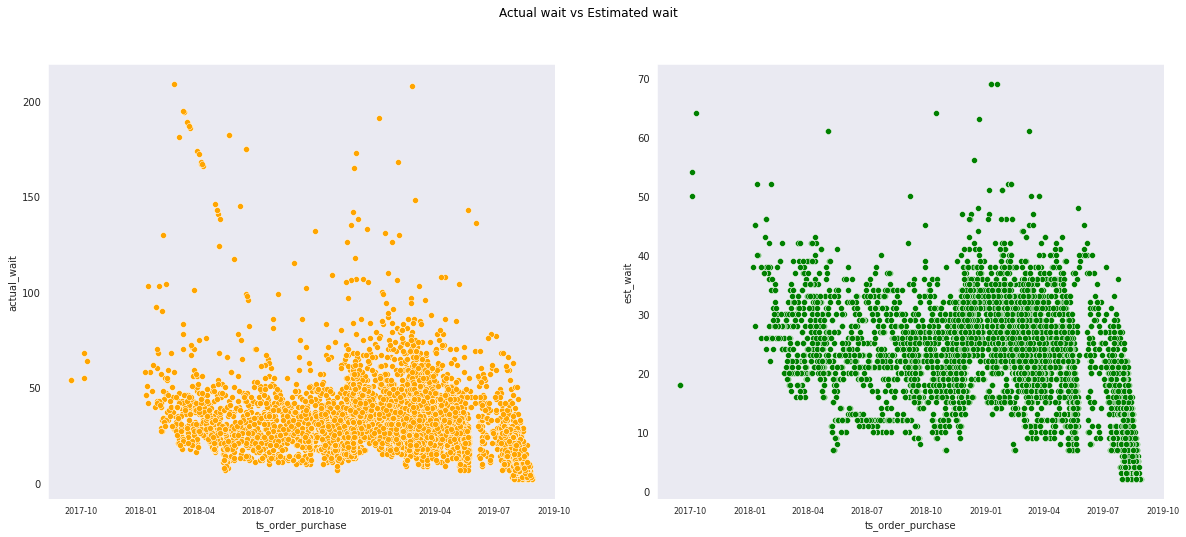

In [86]:
f = plt.figure(figsize=(20, 8))
gs = f.add_gridspec(1, 2) #add grid specifications, 2 rows and 3 col
f.suptitle('Actual wait vs Estimated wait')
#VEDI LINEPLOT SALES DI TUTTO 2018
#GIRA TUTTE LE DATE
# darkgrid
with sns.axes_style("dark"):
    ax = f.add_subplot(gs[0, 0])
    b=sns.scatterplot(x='ts_order_purchase', y='actual_wait', data=delays, color='orange')
    b.tick_params(axis='x', which='major', labelsize=8)

#ticklabels scritte piccole
#solo labels x
#b.set_yticklabels(b.get_yticks(), size = 15)
with sns.axes_style("dark"):
    ax = f.add_subplot(gs[0, 1])
    c= sns.scatterplot(x='ts_order_purchase', y='est_wait', data=delays, color='green')
    c.tick_params(axis='x', which='major', labelsize=8)

In [87]:
delays.nunique()

customer_city                      68
geo_latitude_customer              68
geo_longitude_customer             68
geo_admin1_code_customer           17
customer_autonomous_community      17
latest_order_purchase            7588
customer_id                      7826
customer_unique_id               7771
cac_count                           2
cc_count                            2
order_id                         7826
order_status                        1
ts_order_purchase                7610
ts_order_approved                6415
ts_order_delivered_carrier       7043
ts_order_delivered_customer      7550
ts_order_estimated_delivery       378
seller_city                        55
geo_latitude_seller                55
geo_longitude_seller               55
geo_admin1_code_seller             17
seller_autonomous_community        17
seller_id                        1390
order_item_sequence_id             21
product_id                       5178
price                            1662
shipping_cos

PRODUCT PROCESS
Let's get a clear insight of the order process
- customer makes the order
- the seller preprares the order and notifies in his area that the order can be picked up
- the company notifies the carrier that the order is ready to be picked up
- the carrier takes the order
- the order is delivered to the customer

How much does this process take on average in our case ?


In [88]:
#In case of delays dataset the wait of the customer in on average of 30 days
delays['actual_wait'].mean()

30.886274959834747

In [89]:
#in the time shipment process on average the whole process takes 12 days
time_shipment['actual_wait'].mean()

12.007785985226592

In [90]:
#in the delays on average the sellers miss their deadline to give the package to the seller of -0.03(?)
delays['max_time'].mean()

-0.0355790198553885

In [91]:
delays['max_time'].unique()

array([   2.,    7.,    4.,    3.,   -1.,    1.,    5.,   -5.,   -2.,
         12.,  -28.,    0.,    6.,   -7.,  -25.,  -16.,   -6.,  -29.,
        -13.,  -30.,  -46.,   -4.,  -15.,  -12.,  -17.,    8.,   -3.,
        -11.,  -36.,  -18.,  -21.,   -8.,   -9.,   11.,  -20.,  -35.,
        -10.,    9.,  -23.,  -22.,  -37.,  -14.,   10.,  -27.,  -59.,
        -34.,  -41.,  -32.,  -19.,  -31.,  -40.,   13.,  -24.,  -43.,
        -26.,  -42.,  -92.,   19.,  -33.,   25.,   14.,  -49., -117.,
         nan,   15.,   27.,  -52.,  -44.,  -96.,   22.,   32.,  -60.])

In [92]:
numbers = delays['max_time']

fig = go.Figure()
fig.add_trace(go.Histogram(x=numbers, name="count", textfont_size=20, marker_color='#66AD94'))#TO style with different colors
fig.update_layout(
    title_text='Maxtime in Delays Dataset ', 
    xaxis_title_text='Time',
    yaxis_title_text='Count',
  
)

fig.show()

In [93]:
delays[delays['max_time']>0].shape

(5255, 38)

Now creta the dataset used to fit the model

In [94]:
time_shipment['op_carrier'] = time_shipment['ts_order_delivered_carrier'] - time_shipment['ts_order_purchase']

In [95]:
import datetime as dt
time_shipment['op_carrier'] = time_shipment['op_carrier'].dt.days

In [96]:
#we omit negative days in the op_carrier 
time_shipment = time_shipment[time_shipment['op_carrier'] > 0]

In [97]:
time_shipment['diff_actual_carrier_days'] = time_shipment['actual_wait'] - time_shipment['op_carrier']

In [98]:
time_shipment = time_shipment[time_shipment['diff_actual_carrier_days']>0] # diff_actual_carrier_days negative free 

In [99]:
products=products.reset_index()
products

index                        product_id   product_category_name  \
0          0  1e9e8ef04dbcff4541ed26657ea517e5               fragrance   
1          1  3aa071139cb16b67ca9e5dea641aaa2f                  fabric   
2          2  96bd76ec8810374ed1b65e291975717f          sport outdoors   
3          3  cef67bcfe19066a932b7673e239eb23d                    kids   
4          4  9dc1a7de274444849c219cff195d0b71        home accessories   
...      ...                               ...                     ...   
32946  32946  a0b7d5a992ccda646f2d34e418fff5a0               furniture   
32947  32947  bf4538d88321d0fd4412a93c974510e6  tools home improvement   
32948  32948  9a7c6041fa9592d9d9ef6cfe62a71f8c        kitchen & dining   
32949  32949  83808703fc0706a22e264b9d75f04a2e    computer accessories   
32950  32950  106392145fca363410d287a815be6de4        kitchen & dining   

       product_weight_gr  product_length_cm  product_height_cm  \
0                  225.0               16.0               10.0   
1                 1000.0               30.0               18.0   
2                  154.0               18.0                9.0   
3                  371.0               26.0                4.0   
4                  625.0               20.0               17.0   
...                  ...                ...                ...   
32946            12300.0               40.0               40.0   
32947             1700.0               16.0               19.0   
32948             1400.0               27.0                7.0   
32949              700.0               31.0               13.0   
32950             2083.0               12.0                2.0   

       product_width_cm  product_photo_quantity  
0                  14.0                     1.0  
1                  20.0                     1.0  
2                  15.0                     1.0  
3                  26.0                     1.0  
4                  13.0                     4.0  
...                 ...                     ...  
32946              40.0                     2.0  
32947              16.0                     1.0  
32948              27.0                     1.0  
32949              20.0                     2.0  
32950               7.0                     1.0  

[32951 rows x 8 columns]

In [100]:
time_shipment = pd.merge(products[['product_id','product_weight_gr']], time_shipment, on='product_id',how='right')

In [101]:
count = time_shipment.groupby(['order_id'], as_index = False).agg({'order_item_sequence_id': 'max', 'product_id':'nunique', 'seller_id':'nunique', "Distance":'mean', 'op_carrier':'max', 'product_weight_gr':'sum', 'Distance':'max'})

In [102]:
count1 = time_shipment.groupby(['order_id'], as_index = False)['Distance'].mean()
count1.columns = count1.columns.str.replace('Distance', 'mean_distance')

In [103]:
count = pd.merge(count, count1, on = 'order_id',how='left')

In [104]:
count.columns = count.columns.str.replace('Distance', 'max_distance')
count.columns = count.columns.str.replace('order_item_sequence_id', 'number_orders')
count.columns = count.columns.str.replace('product_id', 'number_products')
count.columns = count.columns.str.replace('seller_id', 'number_seller')


count[count['number_seller'] == 5]

order_id  number_orders  number_products  \
8431  1c11d0f4353b31ac3417fbfa5f0f2a8a              7                6   

      number_seller  max_distance  op_carrier  product_weight_gr  \
8431              5  19155.847003         2.0             7830.0   

      mean_distance  
8431   13318.237612

In [105]:
y = time_shipment[['order_id','actual_wait']]

In [106]:
y = y.drop_duplicates(['order_id'],keep= 'last') 

In [107]:
count = pd.merge(count, y, on='order_id',how='left')

In [108]:
count.to_csv('dataset_4_shipment_model.csv', index=False)